In [1]:
%reset
%matplotlib inline

import netCDF4 as nc
import cmocean
import numpy as np
import xarray as xr
import xrft
from xgcm import Grid
import matplotlib.pyplot as plt
import scipy.interpolate
from dask.diagnostics import ProgressBar
from matplotlib import colors, ticker
import pandas as pd

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [87]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld2 setup
#run=28 #1/16 degree NeverWorld2 setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400

sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/
#print(os)
#plt.rcParams.update({'font.size': 18})

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [2]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/run33
run=33; factor = 1440/86400 #1/32 degree NeverWorld setup
fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
forcing=xr.open_dataset('forcing_00002000.nc', decode_times=False)
init=xr.open_dataset('MOM_IC.nc', decode_times=False)
av=xr.open_dataset('averages_00001902.nc',decode_times=False)
#av=xr.open_mfdataset(['averages_00001502.nc','averages_00001602.nc', 'averages_00001702.nc', 'averages_00001802.nc', 'averages_00001902.nc'],decode_times=False,combine='by_coords')
# print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/scratch/gmarques/NW2_TMP/run33
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [3]:
print(av)

<xarray.Dataset>
Dimensions:     (nv: 2, time: 20, xh: 1920, xq: 1921, yh: 4480, yq: 4481, zi: 16, zl: 15)
Coordinates:
  * xq          (xq) float64 0.0 0.03125 0.0625 0.09375 ... 59.94 59.97 60.0
  * yh          (yh) float64 -69.98 -69.95 -69.92 -69.89 ... 69.92 69.95 69.98
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 1.902e+03 1.908e+03 ... 1.992e+03 1.998e+03
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.01562 0.04688 0.07812 ... 59.92 59.95 59.98
  * yq          (yq) float64 -70.0 -69.97 -69.94 -69.91 ... 69.94 69.97 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 ...
    e2          (time, zi, yh, xh) float32 ...
    uh          (time, zl, yh, xq) float32 ...
    vh          (time, zl, yq, xh) float32 ...
    PV          

In [4]:
lat= (av.yh)     
lon= (av.xh)     

u= av.u[:,0,:,:]#-(av.u[:,0,:,:].mean('time')) #We're removing the temporally-averaged mean flow.
v= av.v[:,0,:,:]#-(av.v[:,0,:,:].mean('time'))
Ld = av.Rd1[:].mean('time')
grid= Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'}, #This tells the grid where xh, xq, yh, and yq are defined.
                        'Y': {'center': 'yh', 'outer': 'yq'}});
#Interpolating u,v to be on the same grid points:
dx= grid.interp(fs.dxCu,axis='X')
dy= grid.interp(fs.dyCv,axis='Y')
u = grid.interp(u,axis='X')
v = grid.interp(v,axis='Y')
print(u.shape,v.shape)
Ld = av.Rd1[:].mean('time')

(20, 4480, 1920) (20, 4480, 1920)


In [5]:
print('min dx:',2*np.pi*6378000*np.cos(70*np.pi/180)/360/32,'km')
print('max dx:',2*np.pi*6378000/360/32,'km')

min dx: 1189.7715747288576 km
max dx: 3478.6593653811983 km


In [6]:
av.u

<xarray.DataArray 'u' (time: 20, zl: 15, yh: 4480, xq: 1921)>
[2581824000 values with dtype=float32]
Coordinates:
  * xq       (xq) float64 0.0 0.03125 0.0625 0.09375 ... 59.91 59.94 59.97 60.0
  * yh       (yh) float64 -69.98 -69.95 -69.92 -69.89 ... 69.92 69.95 69.98
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) float64 1.902e+03 1.908e+03 ... 1.992e+03 1.998e+03
Attributes:
    long_name:      Zonal velocity
    units:          m s-1
    cell_methods:   zl:mean yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


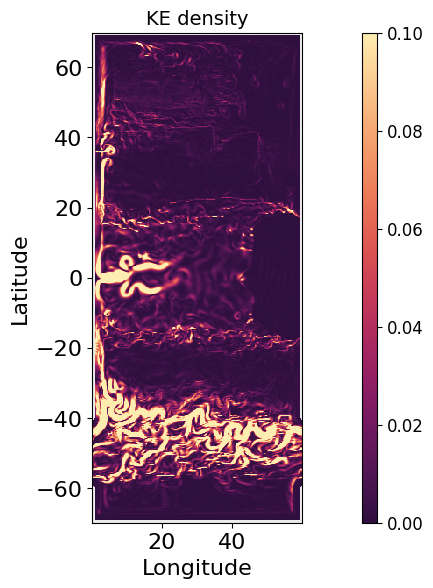

In [90]:
#Plotting KE for whole domain
fig = plt.figure(figsize=(5, 7), dpi=100, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)


ax1.set_title('KE density',fontsize=14)

KE=(u**2+v**2)*0.5
plotted =ax1.pcolor(lon,lat,KE[-1,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=1e-1)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=12);
#ax2.set_title('$log_{10}(KE)$')
#
plt.show()

## We will now change the x-coordinates to be in units of meters rather than degrees.

(4480, 1920)


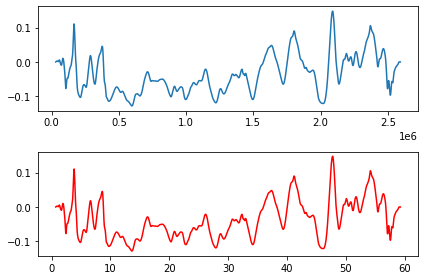

In [7]:
xi=dx.cumsum(axis=1)-dx[:,0] #subtract first dx so that we start at x=0m.
#xi=(xi-xi[:,479]) #Center the grid along the center longitude.


index=100
xline= xi[index,:]
uline= u[:,index,:]; uline=uline.assign_coords(xh=xline)
vline= v[:,index,:]; vline=uline.assign_coords(xh=xline)

print(xi.shape)

fig, ax = plt.subplots(2)
ax[0].plot(uline.xh,uline[0,:])
ax[1].plot(u[0,index,:].xh,u[0,index,:],'r')
plt.tight_layout()

### Computing the 1D spectrum at one latitude

In [8]:
time=np.arange(0,1,1)

boundary=50 #50
for i in range(130,131):#,len(lat)):

    
    xline= xi[i,boundary:-boundary]
    uline= u[time,i,boundary:-boundary].fillna(0.); uline=uline.assign_coords(xh=xline) 
    vline= v[time,i,boundary:-boundary].fillna(0.); vline=vline.assign_coords(xh=xline)
    Ldline= Ld[i,boundary:-boundary]; Ldline=Ldline.assign_coords(xh=xline)
    
    uiso2 = xrft.power_spectrum(uline,dim=['xh'], scaling="density",window='hann', detrend='linear').compute() #, window='hann/hamming', detrend='linear'
    viso2 = xrft.power_spectrum(vline,dim=['xh'], scaling="density",window='hann', detrend='linear').compute()
    ekeiso = .5*(uiso2 + viso2).mean('time') #Computing the mean spectrum first, then finding max wavenumber later.
    nk = int(len(ekeiso)/2.)

    ekeiso=ekeiso[nk+1:]    # half of the latitude array size
    wavenumber= (ekeiso.freq_xh*1e3*2*np.pi)
    LD_wavenumber=(1/(Ldline/1000)).mean('xh')
    ES_wavenumber=ekeiso[3:].idxmax(dim='freq_xh')*1000*2*np.pi #don't count first 3 wavenumbers
  
    
    alt_PS=0.5*(np.abs(np.fft.rfft(uline))**2)+0.5*(np.abs(np.fft.rfft(vline))**2) #units m2/s2
    #alt_PS=alt_PS/(int(len(xline))**2)       #if using scaling spectrum, preserves units m2/s2 (my interpretation)
    alt_PS=alt_PS*np.array(dx[i,100]/len(xline)) #if using scaling density, units m3/s2
    alt_freq= np.fft.rfftfreq(uline.size,np.array(dx[i,100])/(1000*2*np.pi))
    
    centroid = np.nansum(ekeiso*wavenumber)/np.nansum(ekeiso)
    

In [9]:
test1=alt_PS[0,1:]
test2=ekeiso
test1[0:10]/test2[0:10]

<xarray.DataArray (freq_xh: 10)>
array([6.82629049, 1.59747689, 2.61006969, 2.7435258 , 4.50612312,
       0.5201314 , 4.39968292, 7.34400535, 4.73116531, 2.43989765])
Coordinates:
    yh       float64 -65.92
  * freq_xh  (freq_xh) float64 3.871e-07 7.743e-07 ... 3.484e-06 3.871e-06

In [10]:
wavenumber.shape

(909,)

In [11]:
xline

<xarray.DataArray (xh: 1820)>
array([  70961.50616533,   72380.73628864,   73799.96641194, ...,
       2649702.64021345, 2651121.87033675, 2652541.10046006])
Coordinates:
    yh       float64 -65.92
  * xh       (xh) float64 1.578 1.609 1.641 1.672 ... 58.33 58.36 58.39 58.42

In [12]:
alt_freq[1:].shape

(910,)

Text(0, 0.5, '[m$^3$ s$^{-2}$]')

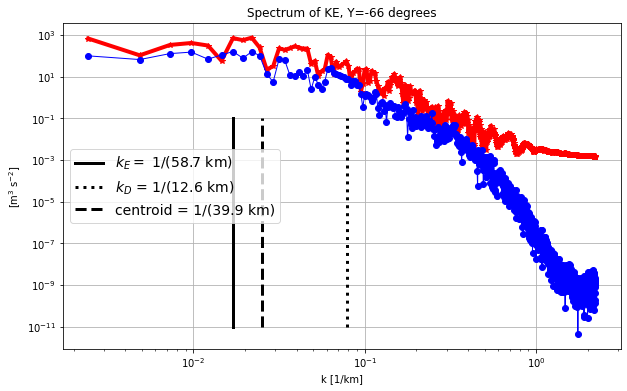

In [13]:
fig, ax = plt.subplots(figsize=(10,6))


plt.plot(alt_freq[1:],alt_PS[0,1:],'-*r',linewidth=4)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
plt.plot(wavenumber,ekeiso,'-ob',linewidth=1)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber

l1=plt.plot([ES_wavenumber,ES_wavenumber], [1e-11,1e-1],color='k',linewidth=3,label='$k_E=$ 1/(%.1f km)'%(1/ES_wavenumber))
l2=plt.plot([LD_wavenumber,LD_wavenumber], [1e-11,1e-1],':k',linewidth=3,label='$k_D$ = 1/(%.1f km)'%(1/LD_wavenumber))
l2=plt.plot([centroid,centroid], [1e-11,1e-1],'--k',linewidth=3,label='centroid = 1/(%.1f km)'%(1/centroid))

plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE, Y=%.0f degrees'%lat[i])
#plt.ylim([1e-5, 1e-3])
#plt.xlim([1e-4, 1e1])
plt.grid()
plt.xlabel('$\kappa_r (1/km)$')
plt.legend(fontsize=14)

ax.set_xlabel(r'k [1/km]')
ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

### Computing the 1D spectrum at each latitude for all times:

In [15]:
time=np.arange(0,20,1)

lim = 40 #40 for HR
LD_wavenumber=Ld[lim:-lim,0]*0.0
ES_wavenumber=Ld[lim:-lim,0]*0.0
ES_stdev     =Ld[lim:-lim,0]*0.0

centroid      =Ld[lim:-lim,0]*0.0
centroid_stdev=Ld[lim:-lim,0]*0.0

boundary=50
for i in range(lim,len(lat)-lim):#,len(lat)):

    #nantester= u[0,i,:]; 
    #nantester=(~np.isnan(nantester)); res = [i for i, val in enumerate(nantester) if val]
    #print(min(res),max(res));
    #lon1= min(res)+20
    #lon2= max(res)-20
    
    xline= xi[i,boundary:-boundary]
    uline= u[time,i,boundary:-boundary]; uline=uline.assign_coords(xh=xline) 
    vline= v[time,i,boundary:-boundary]; vline=vline.assign_coords(xh=xline)
    Ldline= Ld[i,boundary:-boundary]; Ldline=Ldline.assign_coords(xh=xline)
    
    uiso2 = xrft.power_spectrum(uline,dim=['xh'],scaling="density").compute() #generally don't want window and detrending when using the centroid, they change shape.
    viso2 = xrft.power_spectrum(vline,dim=['xh'],scaling="density").compute()
    ekeiso = .5*(uiso2 + viso2)
    nk = int(len(ekeiso[1])/2.)
    ekeiso=ekeiso[:,nk+1:]    #460 in length, half of the used longitude array (20-940)
    
    ES_stdev[i-lim]     =(1./(ekeiso[:,3:].idxmax(dim='freq_xh')*1000*2*np.pi)).std('time')
    ES_wavenumber[i-lim]=(ekeiso[:,3:].idxmax(dim='freq_xh')*1000*2*np.pi).mean('time') #don't count first 3 wavenumbers, compute most energetic wavenumber then average over time
    LD_wavenumber[i-lim]=(1/(Ldline/1000)).mean('xh')
    wavenumber= (ekeiso.freq_xh*1e3*2*np.pi)
    
    centroid[i-lim] = ((ekeiso*wavenumber).sum('freq_xh')/ekeiso.sum('freq_xh')).mean('time')
    centroid_stdev[i-lim]=(1/((ekeiso*wavenumber).sum('freq_xh')/ekeiso.sum('freq_xh'))).std('time')
    ekeiso=ekeiso.mean('time')
    #ES_wavenumber[i-lim]=(ekeiso[3:].idxmax(dim='freq_xh')*1000*2*np.pi)

    
    
    #ES_wavenumber=ekeiso.idxmax(dim='freq_xh')*1000*2*np.pi 

In [16]:
ekeiso

<xarray.DataArray (freq_xh: 909)>
array([1.28775894e+01, 2.31764588e+00, 2.39718100e+00, 1.81995360e+00,
       2.85377407e+00, 1.17980356e+00, 5.10689110e+00, 1.98128169e+00,
       2.06927323e+00, 7.00818517e-01, 1.06850131e+00, 1.42167251e+00,
       1.34351770e+00, 1.08853713e+00, 1.76884660e+00, 1.23907596e+00,
       8.90332908e-01, 1.77429246e+00, 9.79168921e-01, 5.37012186e-01,
       8.36322360e-01, 5.94967461e-01, 7.02749278e-01, 6.51537773e-01,
       1.31379264e+00, 1.17690395e+00, 5.27022439e-01, 1.14127204e+00,
       1.04021907e+00, 5.67973190e-01, 5.66030983e-01, 8.62755027e-01,
       6.94601609e-01, 9.45970535e-01, 1.36907497e+00, 6.80374801e-01,
       6.50627950e-01, 5.75134930e-01, 4.66638602e-01, 4.37226944e-01,
       1.54974376e+00, 1.58224002e+00, 1.10999863e+00, 8.91761425e-01,
       1.11025369e+00, 6.44165308e-01, 5.49563034e-01, 4.86306061e-01,
       4.16632720e-01, 6.97569685e-01, 5.01631774e-01, 3.53960669e-01,
       2.85508573e-01, 4.24358799e-01, 2.95319171e-01, 4.09438322e-01,
       3.75585484e-01, 5.83788039e-01, 3.77310813e-01, 4.59928254e-01,
       4.43458804e-01, 3.23232859e-01, 3.60489717e-01, 2.46124281e-01,
       2.49714323e-01, 2.10294205e-01, 3.48203598e-01, 3.78032438e-01,
       2.20379295e-01, 1.79999205e-01, 1.78248359e-01, 1.84585338e-01,
       2.36698162e-01, 1.99436359e-01, 1.71019280e-01, 1.38528164e-01,
       1.10917974e-01, 1.40643759e-01, 1.23044968e-01, 1.19943976e-01,
...
       2.49485168e-04, 2.49285237e-04, 2.49178267e-04, 2.49037642e-04,
       2.48911754e-04, 2.48840031e-04, 2.48620452e-04, 2.48485421e-04,
       2.48466090e-04, 2.48364545e-04, 2.48321713e-04, 2.48205433e-04,
       2.48072751e-04, 2.48054152e-04, 2.48023432e-04, 2.47886266e-04,
       2.47733612e-04, 2.47774720e-04, 2.47743089e-04, 2.47594804e-04,
       2.47521502e-04, 2.47483848e-04, 2.47386593e-04, 2.47310140e-04,
       2.47326682e-04, 2.47120705e-04, 2.47058467e-04, 2.47109825e-04,
       2.47072733e-04, 2.46995290e-04, 2.46846281e-04, 2.46776693e-04,
       2.46685300e-04, 2.46671446e-04, 2.46626620e-04, 2.46538886e-04,
       2.46522474e-04, 2.46439629e-04, 2.46361732e-04, 2.46366170e-04,
       2.46265887e-04, 2.46186512e-04, 2.46166221e-04, 2.46090109e-04,
       2.46117354e-04, 2.45960928e-04, 2.45902642e-04, 2.45732315e-04,
       2.45788278e-04, 2.45709669e-04, 2.45620035e-04, 2.45585811e-04,
       2.45575727e-04, 2.45512316e-04, 2.45554994e-04, 2.45468801e-04,
       2.45385995e-04, 2.45349279e-04, 2.45335178e-04, 2.45239286e-04,
       2.45207306e-04, 2.45121405e-04, 2.45038012e-04, 2.45118146e-04,
       2.45066965e-04, 2.45110821e-04, 2.45018497e-04, 2.45030279e-04,
       2.45053665e-04, 2.45157289e-04, 2.45128730e-04, 2.45096981e-04,
       2.45132762e-04, 2.45138596e-04, 2.45110569e-04, 2.45149282e-04,
       2.45138818e-04])
Coordinates:
    yh       float64 68.73
  * freq_xh  (freq_xh) float64 4.355e-07 8.71e-07 ... 0.0003954 0.0003959

Text(0, 0.5, '[m$^3$ s$^{-2}$]')

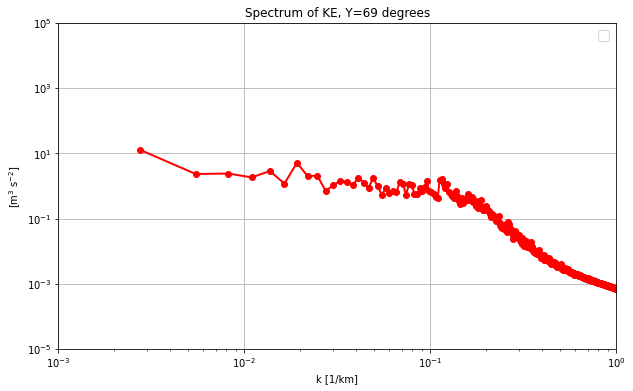

In [17]:
fig, ax = plt.subplots(figsize=(10,6))


plt.plot(wavenumber,ekeiso,'-or',linewidth=2)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
#l1=plt.plot([np.array(ES_wavenumber[-1]),np.array(ES_wavenumber[-1])], [1e-5,1e5],color='k',linewidth=3,label='$k_E=$ 1/(%.1f km)'%(1/ES_wavenumber))
#l2=plt.plot([LD_wavenumber[-1],LD_wavenumber[-1]], [1e-5,1e5],':k',linewidth=3,label='$k_D$ = 1/(%.1f km)'%(1/LD_wavenumber))
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE, Y=%.0f degrees'%lat[i])
plt.ylim([1e-5, 1e5])
plt.xlim([1e-3, 1e0])
plt.grid()
plt.xlabel('$\kappa_r (1/km)$')
plt.legend(fontsize=14)

ax.set_xlabel(r'k [1/km]')
ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

In [158]:
np.array(ES_wavenumber[-1])

array(0.06047149, dtype=float32)

In [159]:
ES_wavenumber.yh

<xarray.DataArray 'yh' (yh: 4400)>
array([-68.734375, -68.703125, -68.671875, ...,  68.671875,  68.703125,
        68.734375])
Coordinates:
  * yh       (yh) float64 -68.73 -68.7 -68.67 -68.64 ... 68.64 68.67 68.7 68.73
    xh       float64 0.01562
Attributes:
    long_name:       h point nominal latitude
    units:           degrees_north
    cartesian_axis:  Y

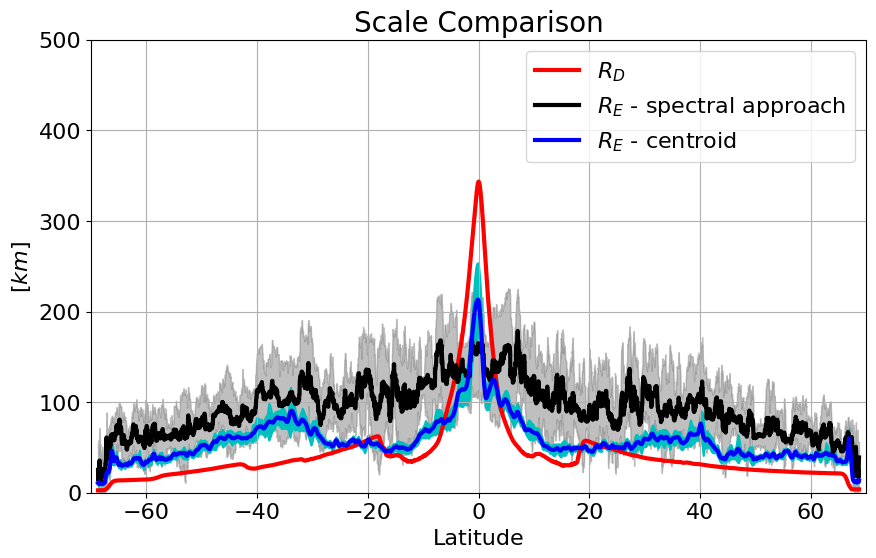

In [22]:

fig, ax = plt.subplots(figsize=(10,6),dpi=100)


plt.plot(LD_wavenumber.yh,1./LD_wavenumber,'-',c='r',linewidth=3,label='$R_D$')
plt.plot(ES_wavenumber.yh,1./ES_wavenumber,'-',c='k',linewidth=3,label='$R_E$ - spectral approach')
plt.fill_between(ES_wavenumber.yh, 1./(ES_wavenumber)+ES_stdev, 1./(ES_wavenumber)-ES_stdev,color=(0.5,0.5,0.5,0.5))

plt.plot(centroid.yh,1./centroid,'-',c='b',linewidth=3,label='$R_E$ - centroid')
plt.fill_between(centroid.yh, 1./(centroid)+centroid_stdev, 1./(centroid)-centroid_stdev,color='c')

plt.title('Scale Comparison',fontsize=20)
plt.ylim([0, 500]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.grid()
plt.xlabel('Latitude',fontsize=16); plt.ylabel('$[km]$',fontsize=16);
plt.legend(fontsize=16)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

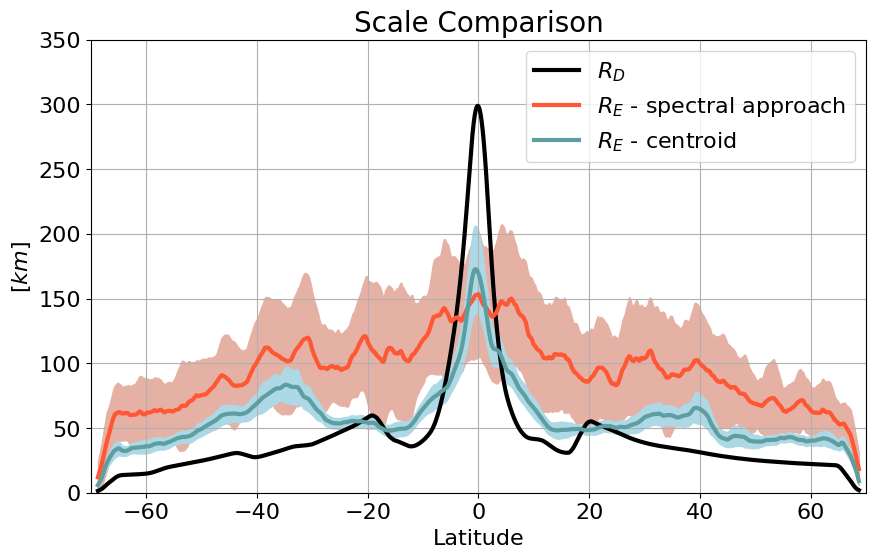

In [55]:

fig, ax = plt.subplots(figsize=(10,6),dpi=100)

window=100
smooth_ES=np.convolve(1./ES_wavenumber, np.ones((window,))/window, mode='same')
smooth_LD=np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same')
smooth_ES_stdev     =np.convolve(ES_stdev, np.ones((window,))/window, mode='same')

smooth_centroid=np.convolve(1./centroid, np.ones((window,))/window, mode='same')
smooth_centroid_stdev=np.convolve(centroid_stdev, np.ones((window,))/window, mode='same')



plt.plot(LD_wavenumber.yh,smooth_LD,'-',c='k',linewidth=3,label='$R_D$')
plt.plot(ES_wavenumber.yh,smooth_ES,'-',c='#FF5733',linewidth=3,label='$R_E$ - spectral approach')
plt.fill_between(ES_wavenumber.yh, smooth_ES+smooth_ES_stdev, smooth_ES-smooth_ES_stdev,color='#e6b1a5')

plt.plot(centroid.yh,smooth_centroid,'-',c='#5F9EA0',linewidth=3,label='$R_E$ - centroid')
plt.fill_between(centroid.yh, smooth_centroid+smooth_centroid_stdev, smooth_centroid-smooth_centroid_stdev,color='#ADD8E6')

plt.title('Scale Comparison',fontsize=20)
plt.ylim([0, 350]); plt.xticks(fontsize=16);
plt.xlim([-70, 70]); plt.yticks(fontsize=16);
plt.grid()
plt.xlabel('Latitude',fontsize=16); plt.ylabel('$[km]$',fontsize=16);
plt.legend(fontsize=16)

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

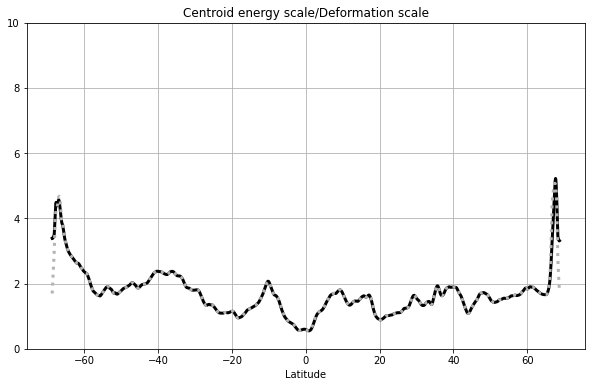

In [36]:
fig, ax = plt.subplots(figsize=(10,6))


 
window=50
smooth_centroid=np.convolve(1./centroid, np.ones((window,))/window, mode='same')
smooth_LD=np.convolve(1./LD_wavenumber, np.ones((window,))/window, mode='same')
smooth_centroid_LD=np.convolve(LD_wavenumber/centroid, np.ones((window,))/window, mode='same')

#plt.plot(ES_wavenumber.yh,c,'-',c=[.7,.7,.7],linewidth=3,label='Energy containing scale')
plt.plot(centroid.yh,(smooth_centroid/smooth_LD),'-',c='k',linewidth=3,label='Energy containing scale')
plt.plot(centroid.yh,smooth_centroid_LD,':',c=[.7,.7,.7],linewidth=3,label='Energy containing scale')


plt.title('Centroid energy scale/Deformation scale')
plt.ylim([0, 10])
#plt.xlim([-6500, 6500])
plt.grid()
plt.xlabel('Latitude'); 
#plt.ylabel('$[km]$');

#ax.set_xlabel(r'k [1/km]')
#ax.set_ylabel(r'[m$^3$ s$^{-2}$]')

In [26]:
#COMPUTE velocity components for decomposing KE:
Nlayers=15

h  = av['h'].mean('time').fillna(0.)
Depth=h.sum('zl')
print('done part 1')
#Outputs are comprised of 100 5-day averages.
u  = av['u'];  u = grid.interp(u,axis='X')#.fillna(0.); 
ubar=u.mean('time')
print('done part 2')
v  = av['v'];  v = grid.interp(v,axis='Y')#.fillna(0.);
vbar=v.mean('time')

uprime=u-ubar
vprime=v-vbar

print(uprime.shape)
area_t=fs['area_t']

done part 1
done part 2
(20, 15, 4480, 1920)


In [27]:
Depth.shape

(4480, 1920)

In [28]:
# The mean BT and BC KE values:
ubar_TW=ubar*h/Depth; 
ubar_BT=ubar_TW.sum('zl')
ubar_BC=ubar-ubar_BT;

vbar_TW=vbar*h/Depth
vbar_BT=vbar_TW.sum('zl')
vbar_BC=vbar-vbar_BT;

KE_mean_BT=0.5*(vbar_BT**2+ubar_BT**2) #dim y,x
KE_mean_BC=(0.5*(vbar_BC**2+ubar_BC**2)*h/Depth).sum('zl') #dim y,x


#Eddy BT and BC KE parts:
uprime_BT=(uprime*h/Depth).sum('zl')
uprime_BC=uprime-uprime_BT
vprime_BT=(vprime*h/Depth).sum('zl')
vprime_BC=vprime-vprime_BT
    
KE_eddy_BT=(0.5*(vprime_BT**2+uprime_BT**2)).mean('time')
KE_eddy_BC=((0.5*(vprime_BC**2+uprime_BC**2)*h/Depth).sum('zl')).mean('time')


# #Total kinetic energy:
KE_BT_tot=KE_eddy_BT+KE_mean_BT
KE_BC_tot=KE_eddy_BC+KE_mean_BC
KE_tot=KE_BT_tot+KE_BC_tot


fraction_BT=KE_BT_tot/KE_tot
fraction_BT_mean=KE_mean_BT/KE_tot
fraction_BT_eddy=KE_eddy_BT/KE_tot

fraction_BC=KE_BC_tot/KE_tot#when you divide zero/zero it's a nan
fraction_BC_mean=KE_mean_BC/KE_tot
fraction_BC_eddy=KE_eddy_BC/KE_tot

KE_eddy = KE_eddy_BT+ KE_eddy_BC
KE_mean = KE_mean_BT+ KE_mean_BC

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, '1/32$^\\circ$ BT,BC EKE fractions')

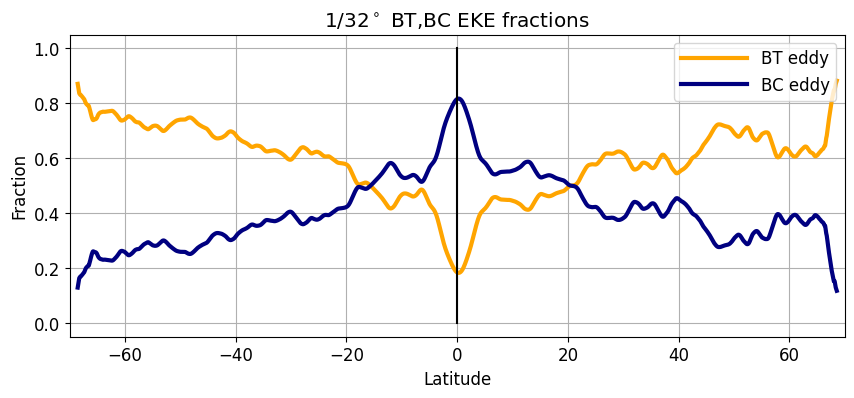

In [170]:
window=50

plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
plt.plot(fraction_BT.yh,np.convolve(np.nanmean(KE_eddy_BT/KE_eddy,axis=1), np.ones((window,))/window, mode='same'),'-',c='#ffa500',linewidth=3)

plt.grid()
plt.plot(fraction_BT.yh,np.convolve(np.nanmean(KE_eddy_BC/KE_eddy,axis=1), np.ones((window,))/window, mode='same'),'-',c=[0,0,.5],linewidth=3)


plt.legend(['BT eddy','BC eddy'],loc='upper right',fontsize=12,handlelength=4)
plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.xlim(-70, 70)
#plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/32$^\circ$ BT,BC EKE fractions')

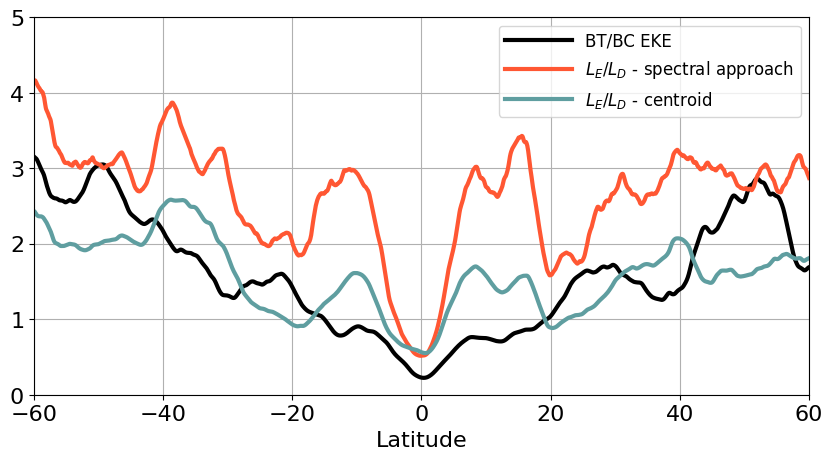

In [64]:
window=100

plt.figure(figsize=(10, 5), dpi= 100, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
yh_center=av.yh[lim:-lim]
Eddy_BC=(KE_eddy_BC.mean('xh'))[lim:-lim];
Eddy_BT=(KE_eddy_BT.mean('xh'))[lim:-lim];

BT_BC=np.convolve((Eddy_BT/Eddy_BC), np.ones((window,))/window, mode='same')
LES_LD=np.convolve((LD_wavenumber/ES_wavenumber), np.ones((window,))/window, mode='same')
LEC_LD=np.convolve((LD_wavenumber/centroid), np.ones((window,))/window, mode='same')

bound1=40; bound2=-40
plt.plot(yh_center[bound1:bound2],BT_BC[bound1:bound2],'-',c='k',linewidth=3)

plt.plot(yh_center[bound1:bound2],LES_LD[bound1:bound2],'-',c='#FF5733',linewidth=3)
plt.plot(yh_center[bound1:bound2],LEC_LD[bound1:bound2],'-',c='#5F9EA0',linewidth=3)


plt.legend(['BT/BC EKE','$L_E/L_D$ - spectral approach','$L_E/L_D$ - centroid'],loc='upper right',fontsize=12,handlelength=4)
#plt.plot([0, 0],[0, 1],'-',color=[0,0,0])
plt.ylim([0, 5]); plt.xticks(fontsize=16);
plt.xlim([-60, 60]); plt.yticks(fontsize=16);
plt.xlabel('Latitude',fontsize=16)
#plt.ylabel('Fraction')
#plt.title('1/32$^\circ$')
plt.grid()

In [74]:
plt.rcParams.update({'font.size': 12})

/glade/work/eyankovsky/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


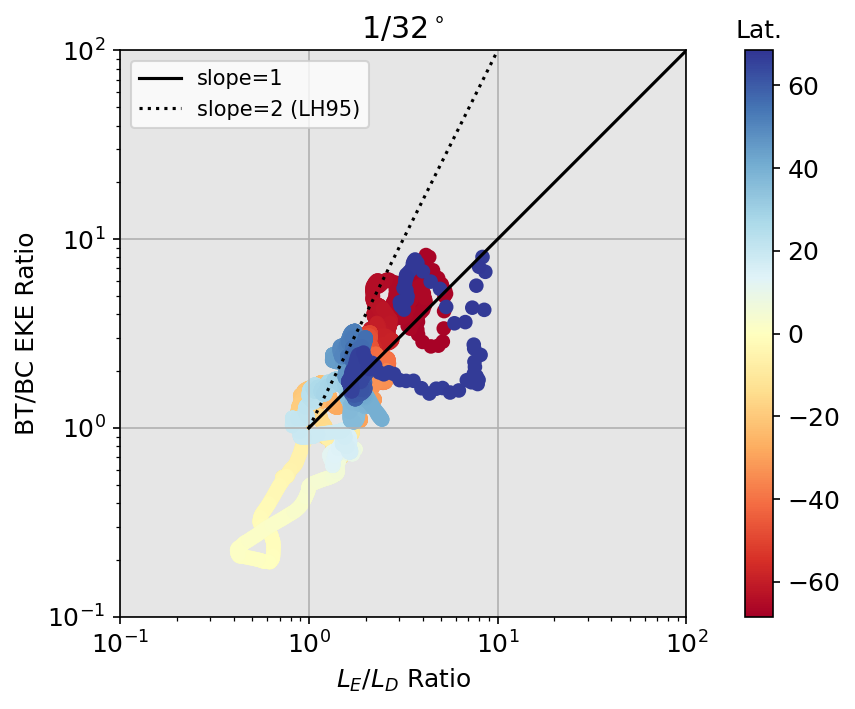

In [76]:

plt.figure(figsize=(10, 5), dpi= 150, facecolor='w', edgecolor='k')
#plt.plot(yh,np.nanmean(fraction_BT,axis=1),'-',c='#82cafc',linewidth=3)
yh_center=av.yh[lim:-lim]
Eddy_BC=(KE_eddy_BC.mean('xh'))[lim:-lim];
Eddy_BT=(KE_eddy_BT.mean('xh'))[lim:-lim];
BT_BC=(Eddy_BT/Eddy_BC)
LE_LD=(LD_wavenumber/centroid)

bound1=10; bound2=-10
plt.scatter(LE_LD[bound1:bound2],BT_BC[bound1:bound2],c=yh_center[bound1:bound2], cmap='RdYlBu')


#plt.xlim(0,5)
#plt.ylim(0,5);
plt.ylim([1e-1, 1e2])
plt.xlim([1e-1, 1e2])
plt.xscale('log')
plt.yscale('log')

#plt.plot([1e0,1e2],[1e0,1e1],':k',linewidth=2)
plt.ylabel('BT/BC EKE Ratio')
plt.xlabel('$L_E/L_D$ Ratio')
plt.title('1/32$^\circ$')
plt.grid()
clb=plt.colorbar()
clb.ax.set_title('Lat.',fontsize=12)


coefficients = np.polyfit(np.log10(LE_LD[bound1:bound2]), np.log10(BT_BC[bound1:bound2]), 1)
polynomial = np.poly1d(coefficients)
log10_y_fit = polynomial(np.log10(LE_LD[bound1:bound2])) 
#
#plt.plot(LE_LD[bound1:bound2], 10**log10_y_fit, 'k-',label='regression slope %.4f'% (polynomial[1]))  
plt.plot([1,100], [1,100], 'k-',label='slope=1')  
plt.plot([1,10], [1,100], 'k:',label='slope=2 (LH95)') 
plt.legend(fontsize=10)
ax = plt.axes()
ax.set_facecolor([0.9,0.9,0.9])
plt.gca().set_aspect('equal')